# ANTICOAGULATION AND THE IMPACT OF COVID-19

In response to the onset of the COVID-19 pandemic and the implementation of “lockdown”, the NHS responded to deliver healthcare services in a manner that did not promote the spread of COVID-19. [NHS England issued anticoagulant services guidance](https://www.england.nhs.uk/coronavirus/wp-content/uploads/sites/52/2020/03/C0077-Specialty-guide_Anticoagulant-services-and-coronavirus-v1-31-March.pdf) in late March to support practices and local organisations manage their anticoagulant services including identifying patients suitable for switching from warfarin, which requires frequent blood tests with sometimes unpredictable intervals, to direct oral anticoagulants (DOACs) that require less frequent testing with predictable intervals.

OpenPrescribing has a measure on the [prescribing of DOACs as proportion of all DOACs and warfarin](https://openprescribing.net/measure/doacs/) and in this notebook we will investigate further any changes since the onset of COVID-19.

In [8]:
#import libraries required for analysis
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq, charts, maps
import os

In [9]:
sql1 = '''
SELECT
  month,
  pct_id,
  sum(numerator) as total_doac_items,
  sum(denominator) as total_doac_warfain,
  calc_value
FROM
  `ebmdatalab.measures.ccg_data_doacs` AS p
GROUP BY
month,
pct_id,
calc_value
'''

df_doac_measure = bq.cached_read(sql1, csv_path=os.path.join('..', 'data', 'df_doac_measure.csv'))
df_doac_measure['month'] = pd.to_datetime(df_doac_measure['month'])
df_doac_measure.rename(columns={'pct_id':'pct'}, inplace=True) ##prep for maps library whe  pct must be colum name
df_doac_measure.head(5)

,month,pct,total_doac_items,total_doac_warfain,calc_value
0,2015-06-01,00R,249,4770,0.052201
1,2020-05-01,00R,2770,5833,0.474884
2,2015-08-01,00R,293,4584,0.063918
3,2020-02-01,03R,5371,11746,0.457262
4,2018-09-01,03R,4069,12162,0.334567


In [10]:
sql2 = '''
SELECT
  month,
  SUM(CASE
      WHEN SUBSTR(bnf_code,8,8)='Y0____AA' THEN quantity * 0.5   #riva 10mg
      WHEN SUBSTR(bnf_code,8,8)='Y0____AB' THEN quantity * 0.75  #riva 15mg
      WHEN SUBSTR(bnf_code,8,8)='Y0____AD' THEN quantity * 0.125 #riva 2.5mg
      WHEN SUBSTR(bnf_code,8,8)='Z0____AA' THEN quantity * 0.25  #apix 2.5mg
      WHEN SUBSTR(bnf_code,8,8)='Z0____AB' THEN quantity * 0.5   #apix 5mg
      WHEN SUBSTR(bnf_code,8,8)='AA____AB' THEN quantity * 0.5   #edoxab 30mg
      WHEN SUBSTR(bnf_code,8,8)='AA____AA' THEN quantity * 0.25  #edoxaban 15mg
      WHEN SUBSTR(bnf_code,8,8)='X0____AB' THEN quantity * 0.37  #dabig 110mg
      WHEN SUBSTR(bnf_code,8,8)='X0____AC' THEN quantity * 0.5   #dabig 150mg
      WHEN SUBSTR(bnf_code,8,8)='Y0____AA' THEN quantity * 0.25  #dabi 75mg
      ELSE quantity END) AS doac_ddd
FROM
  ebmdatalab.hscic.normalised_prescribing AS rx
WHERE
 bnf_code NOT LIKE '0208020Y%AE' AND #riva combo pack
 (bnf_code LIKE '0208020Z0%' OR #Apixaban
  bnf_code LIKE '0208020X0%' OR #Dabigatran
  bnf_code LIKE '0208020AA%' OR #Edoxaban 
  bnf_code LIKE '0208020Y0%' )  #Rivaroxaban
GROUP BY
  month,
  bnf_name,
  bnf_code
ORDER BY
  month
'''

df_doacs = bq.cached_read(sql2, csv_path=os.path.join('..', 'data', 'df_doacs.csv'))
df_doacs['month'] = pd.to_datetime(df_doacs['month'])
df_doacs.head(5)

,month,doac_ddd
0,2010-08-01 00:00:00+00:00,2560.0
1,2010-08-01 00:00:00+00:00,310.0
2,2010-08-01 00:00:00+00:00,567.0
3,2010-08-01 00:00:00+00:00,38.0
4,2010-08-01 00:00:00+00:00,280.0


Daily Defined Doeses (DDD) is the a [WHO classication system for medicines]. It allows comparisons through measurement and is defined as _the assumed average maintenance dose per day for a drug used for its main indication in adults_. 
- rivaroxaban DDD 20mg   Ref: https://www.whocc.no/atc_ddd_index/?code=B01AF01 
- edoxaban    DDD 60mg   Ref: https://www.whocc.no/atc_ddd_index/?code=B01AF03
- dabigatran  DDD 300mg  Ref: https://www.whocc.no/atc_ddd_index/?code=B01AE07
- apixaban    DDD 10mg   Ref: https://www.whocc.no/atc_ddd_index/?code=B01AF02

*Formula*
Amount of DDDs on an Rx = (mg in presentation / mg in DDD WHO table) * quantity 

(0, 50943648.6)

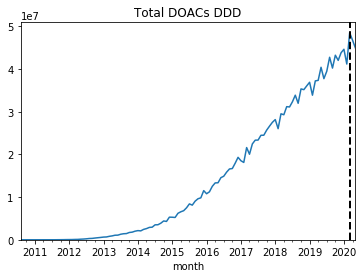

In [11]:
ax = df_doacs.groupby(["month"])['doac_ddd'].sum().plot(kind='line', title="Total DOACs DDD")
ax.axvline(pd.to_datetime('2020-03-30'), color='black', linestyle='--', lw=2) 
plt.ylim(0, )

(0, 1167352.75)

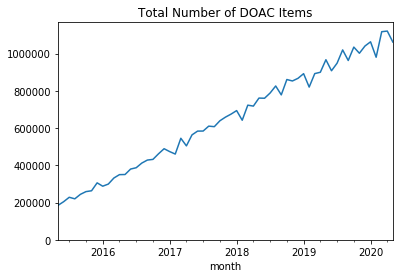

In [12]:
# measure graph
ax = df_doac_measure.groupby(["month"])['total_doac_items'].sum().plot(kind='line', title="Total Number of DOAC Items")
#ax.axvline(pd.to_datetime('2019-04-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, )

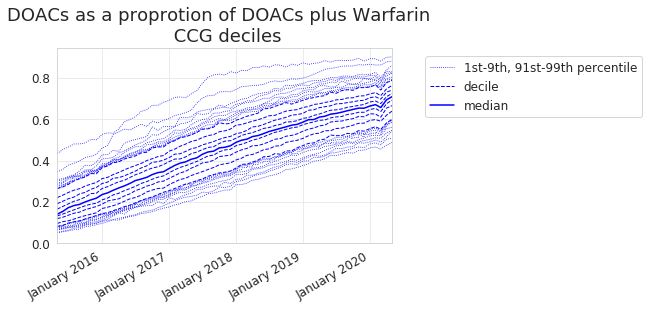

In [17]:
#create sample deciles & prototype measure
charts.deciles_chart(
        df_doac_measure,
        period_column='month',
        column='calc_value',
        title="DOACs as a proprotion of DOACs plus Warfarin  \n CCG deciles",
        show_outer_percentiles=True)

#add in example CCG (Devon)
df_subject = df_doac_measure.loc[df_doac_measure['pct'] == '08H']
plt.plot(df_subject['month'], df_subject['calc_value'], 'r--')

plt.show()